In [23]:
import numpy as np
import pydot
from pydrake.all import (
    DiagramBuilder,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    StartMeshcat,
    MeshcatVisualizer,
    SceneGraph,
    Simulator,
    AddMultibodyPlantSceneGraph,
    LeafSystem,
    LeafSystem_,
    ExternallyAppliedSpatialForce,
    ExternallyAppliedSpatialForce_,
    TemplateSystem,
    AbstractValue,
    SpatialForce,
    SpatialForce_,
    CollisionFilterDeclaration,
    GeometrySet
)
from pydrake.examples import (
    QuadrotorGeometry
)
from IPython.display import display, SVG, Image

from underactuated.scenarios import AddFloatingRpyJoint

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
@TemplateSystem.define("TensileForce_")
def TensileForce_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, length, hooke_K, anchor_point, body_index, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.length = length # In meters, > 0
            self.hooke_K = hooke_K # Hooke's law spring constant, > 0
            self.anchor_point = anchor_point # 3d point, given in the world frame
            self.body_index = body_index # Index of the affected bod from the plant
            
#             self.state_input = self.DeclareAbstractInputPort("State_Input",
#                                                             )
            self.state_input = self.DeclareVectorInputPort("state_input", size=12)
            self.force_output = self.DeclareAbstractOutputPort("force_output",
                                                              alloc=lambda: AbstractValue.Make(                                             
                                                               [ExternallyAppliedSpatialForce_[T]()]),
                                                              calc=self.OutputForce)
        
        def OutputForce(self, context, output):
            state = self.state_input.Eval(context)
            pos = state[0:3]
            dist = np.linalg.norm(pos - self.anchor_point)
            
            f_mag = self.hooke_K * (dist - self.length)
            f_dir = (self.anchor_point - pos) / dist
            f = f_mag * f_dir
            
            F_Bq_W = SpatialForce_[T](np.zeros((3,1)), f.reshape(-1,1))
            p_BoBq_B = np.zeros(3) # Assume the force is applied at the body origin

            o = ExternallyAppliedSpatialForce_[T]()
            o.body_index = self.body_index
            o.F_Bq_W = F_Bq_W
            o.p_BoBq_B = p_BoBq_B
            output.set_value([o])
        
        def _construct_copy(self, other, converter=None,):
            Impl._construct(self, other.length, other.hooke_K, other.anchor_point,
                            other.body_index, converter=converter)
    
    return Impl

# Thanks David!
# https://stackoverflow.com/a/72121171/9796174
@TemplateSystem.define("SpatialForceConcatinator_")
def SpatialForceConcatinator_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, N_inputs, converter = None):
            LeafSystem_[T].__init__(self, converter)
            self.N_inputs = N_inputs
            self.Input_ports = [self.DeclareAbstractInputPort(f"Spatial_Force_{i}",
                                AbstractValue.Make([ExternallyAppliedSpatialForce_[T]()]))
                                for i in range(N_inputs)]
        
            self.Output_port = self.DeclareAbstractOutputPort("Spatial_Forces",
                                           lambda: AbstractValue.Make(                                             
                                           [ExternallyAppliedSpatialForce_[T]()
                                              for i in range(N_inputs)]),
                                           self.Concatenate)

        def Concatenate(self, context, output):
            out = []
            for port in self.Input_ports:
                out += port.Eval(context)
            output.set_value(out)
        
        def _construct_copy(self, other, converter=None,):
            Impl._construct(self, other.N_inputs, converter=converter)
    
    return Impl

# Default instantations
TensileForce = TensileForce_[None]
SpatialForceConcatinator = SpatialForceConcatinator_[None]

In [4]:
def make_n_quadrotor_system(n):
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    parser = Parser(plant)
    parser.SetAutoRenaming(True)
    quadrotor_model_instances = []
    for i in range(n):
        (model_instance,) = parser.AddModelsFromUrl(
            "package://drake/examples/quadrotor/quadrotor.urdf"
        )
        quadrotor_model_instances.append(model_instance)
        # By default the multibody has a quaternion floating base.  To match
        # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
        # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
        # instead of ṙ, ṗ, ẏ.
        AddFloatingRpyJoint(
            plant,
            plant.GetFrameByName("base_link", model_instance),
            model_instance,
            use_ball_rpy=False,
        )
    
    plant.Finalize()

    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.
    
    # Now we can add in propellers as an external force on the MultibodyPlant.
    prop_info = []
    tensile_forces = []
    for model_instance in quadrotor_model_instances:
        body_index = plant.GetBodyByName("base_link", model_instance).index()
        # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
        prop_info += [
            PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
            PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
            PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
            PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
        ]
        tensile_force = builder.AddSystem(TensileForce(1, 10, np.zeros(3), body_index))
        builder.Connect(
            plant.get_state_output_port(model_instance),
            tensile_force.state_input
        )
        tensile_forces.append(tensile_force)

    propellers = builder.AddNamedSystem("propeller", Propeller(prop_info))
    
    combiner = builder.AddNamedSystem("combiner", SpatialForceConcatinator(2))
    builder.Connect(
        propellers.get_output_port(),
        combiner.Input_ports[0]
    )
    builder.Connect(
        combiner.Output_port,
        plant.get_applied_spatial_force_input_port()
    )
    
    tensile_combiner = builder.AddNamedSystem("tensile_combiner", SpatialForceConcatinator(n))
    for tensile_force, combiner_port in zip(tensile_forces, tensile_combiner.Input_ports):
        builder.Connect(
            tensile_force.force_output,
            combiner_port
        )
    builder.Connect(
        tensile_combiner.Output_port,
        combiner.Input_ports[1]
    )
    
    builder.Connect(
        plant.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")

    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    
    return builder.Build(), plant

In [5]:
diagram, plant = make_n_quadrotor_system(3)

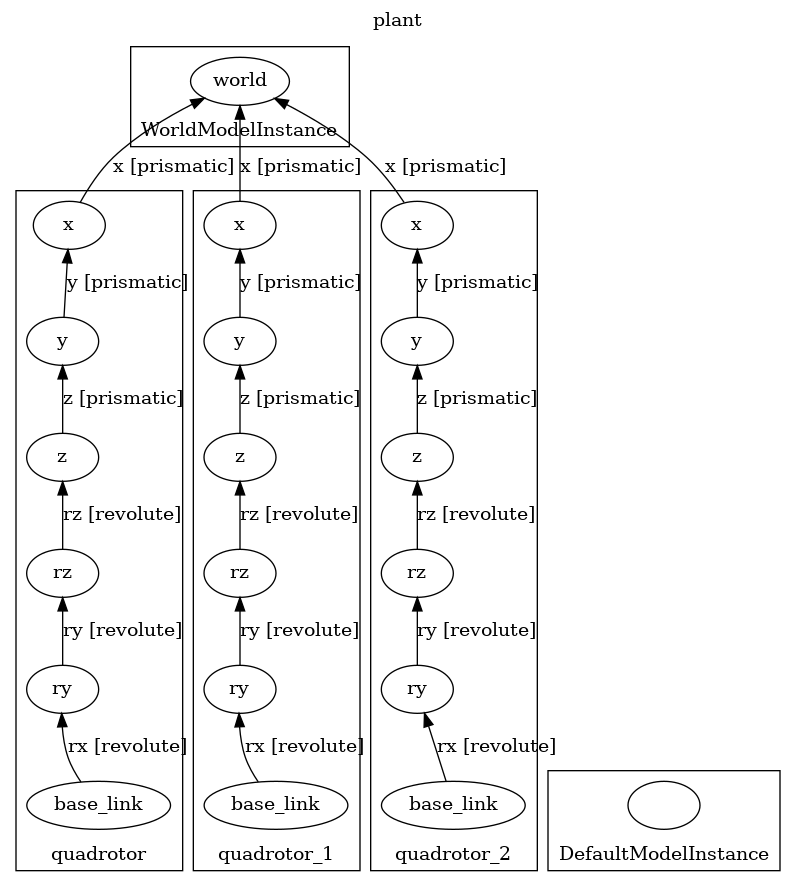

In [6]:
display(
    Image(
        pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_png()
    )
)

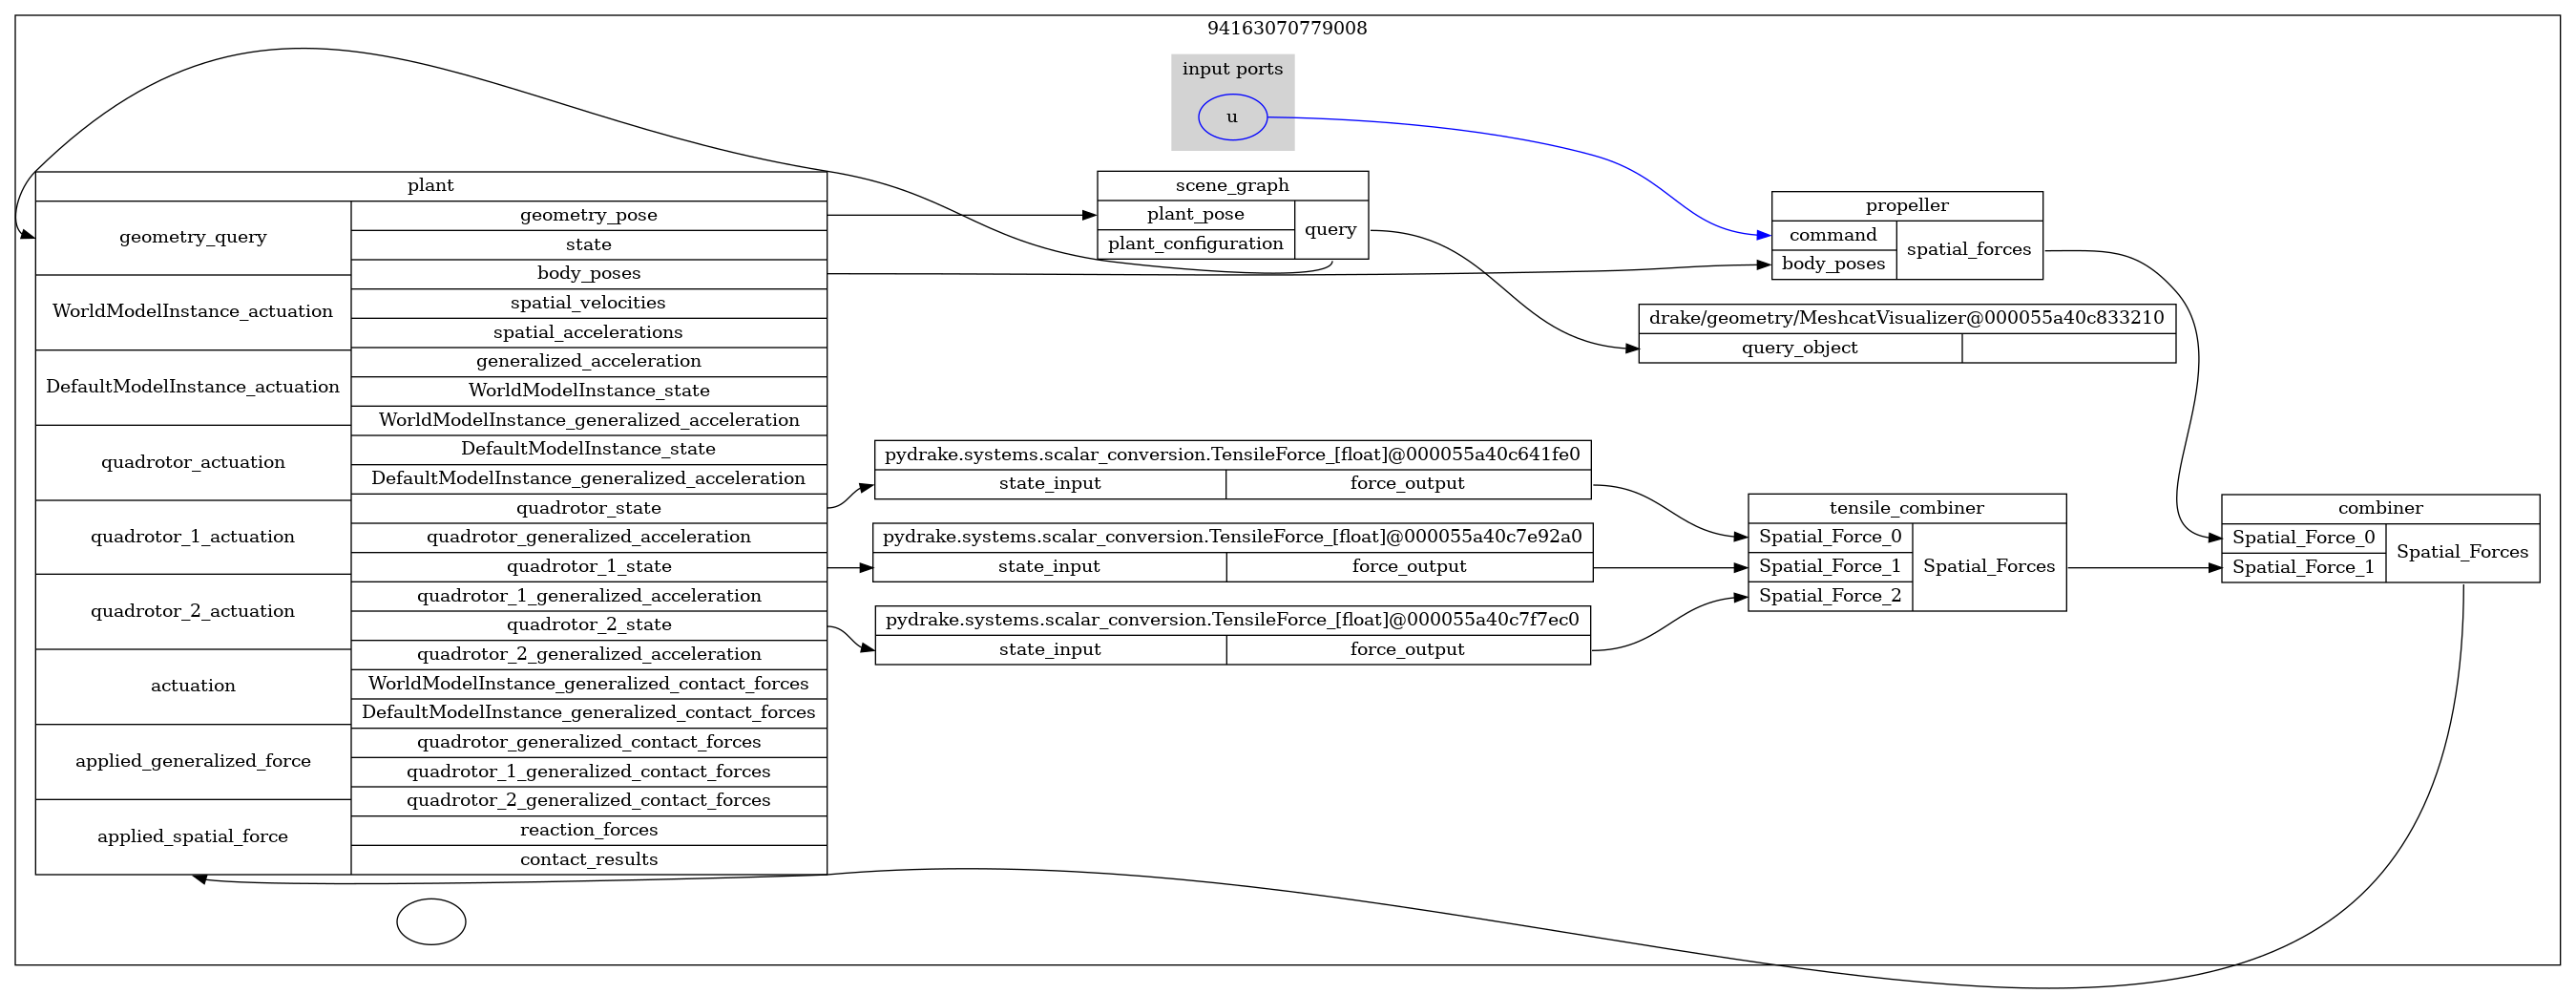

In [7]:
display(
    Image(
        pydot.graph_from_dot_data(diagram.GetGraphvizString())[
            0
        ].create_png()
    )
)

In [8]:
def CreateNullExternalForce(plant):
    f = ExternallyAppliedSpatialForce()
    f.body_index = plant.world_body().index()
    return f

In [ ]:
def DisableCollisionChecking(sg):
    sg_context = sg.GetMyContextFromRoot(context)
    cfm = sg.collision_filter_manager(sg_context)

    query_object = sg.get_query_output_port().Eval(sg_context)
    inspector = query_object.inspector()
    
    quads = GeometrySet()
    gids = inspector.GetAllGeometryIds()
    for gid in gids:
        # Might want to handle the case where not all geometries are collision geometries?
        quads.Add(gid)
    cfd = CollisionFilterDeclaration()
    cfd.ExcludeWithin(quads)
    cfm.Apply(cfd)

In [ ]:
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1)
context = simulator.get_mutable_context()

u = diagram.GetInputPort("u")
u.FixValue(context, np.zeros(u.size()))

sg = diagram.GetSubsystemByName("scene_graph")
DisableCollisionChecking(sg)

# CreateNullExternalForce(diagram.GetSubsystemByName("plant"))

# combiner_system = diagram.GetSubsystemByName("combiner")
# combiner_empty_port = combiner_system.Input_ports[1]
# combiner_empty_port.FixValue(combiner_system.GetMyContextFromRoot(context), [CreateNullExternalForce(plant)])

# Simulate
while True:
    context.SetTime(0.0)
    context.SetContinuousState(
        0.5
        * np.random.randn(
            context.num_continuous_states(),
        )
    )
    simulator.Initialize()
    simulator.AdvanceTo(5)